In [109]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [110]:
#All the imports
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout, BatchNormalization, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")


# **The first model we tried**

### We named it model 2 afterwards

In [111]:
PIC_DIR = 'add here the path to your image folder'
    
IMAGES_COUNT = 4700 #change the images to upload
LATENT_DIM = 32
CHANNELS = 3
ORIG_WIDTH = 48
ORIG_HEIGHT = 48
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH -diff, ORIG_HEIGHT - diff)

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).resize((WIDTH,HEIGHT))
    pic.thumbnail((128,128))
    images.append(np.uint8(pic))

100%|██████████| 20/20 [00:00<00:00, 521.61it/s]


In [112]:
images = expand_dims(images, axis=-1)
images = images.astype('float32')
images = (images - 127.5) / 127.5
print(images.shape)


(20, 128, 128, 1)


In [113]:
def define_generator():
  model = Sequential()
  n_nodes = 128 * 16 * 16
  model.add(Dense(n_nodes, input_dim=LATENT_DIM))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((16, 16, 128)))
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(1, (16,16), activation='tanh', padding='same'))
  return model

def define_discriminator(in_shape=(128,128,1)):
  model = Sequential()
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))
  opt = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model


def define_gan(generator, discriminator):
  discriminator.trainable = False
  model = Sequential()
  model.add(generator)
  model.add(discriminator)
  opt = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

discriminator = define_discriminator()
generator = define_generator()
gan = define_gan(generator, discriminator)


In [ ]:
iters = 5000
batch_size = 16 
import time
RES_DIR = 'add here the file where you want to store the results'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    

    combined_images = np.concatenate([generated, real])
    
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    if step % 50 == 49:
        gan.save_weights('./drive/My Drive/gan.h5')

        print(step + 1, iters, d_loss, a_loss, time.time() - start_time)

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1


plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses)
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()


# **Then we tried other models** 

#### For the following models we changed the way of loading the images 

In [115]:
PIC_DIR = 'add here the path to your images folder'
IMAGES_COUNT = 4700 
ORIG_WIDTH = 48
ORIG_HEIGHT = 48
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH -diff, ORIG_HEIGHT - diff)

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).convert('RGB').resize((WIDTH,HEIGHT))
    pic.thumbnail((128,128))
    images.append(np.uint8(pic))

100%|██████████| 100/100 [00:00<00:00, 759.24it/s]


In [116]:
images = np.array(images) / 255
print(images.shape)

(100, 128, 128, 3)


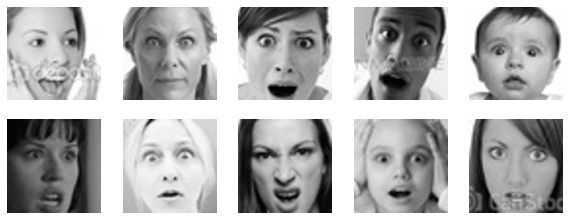

In [117]:
from matplotlib import pyplot as plt
plt.figure(1, figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()


# **Model 1**

In [120]:
def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(256 * 32 * 32) (gen_input)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU()(x)
    x = Reshape((32, 32, 256))(x)
    x = Dropout(0.4)(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, 5, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU()(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, 5, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(32, 5, padding='same')(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(3, 5, padding='same', activation ='sigmoid')(x)

    generator = Model(gen_input, x)
    return generator

def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))
    x = Conv2D(128, 5, strides=2, padding = 'same')(disc_input)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.4)(x)
    x = Conv2D(256, 5, strides=2, padding = 'same')(disc_input)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.4)(x)
    x = Conv2D(512, 5, strides=2, padding = 'same')(disc_input)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.4)(x)
    x = Conv2D(1024, 5, strides=1, padding = 'same')(disc_input)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )
    return discriminator
optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)


# **Model 3**

In [122]:
def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 32 * 32)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((32, 32, 128))(x)
   
    x = Conv2DTranspose(128, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(128, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(CHANNELS,32 , activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)

    return generator

def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(128, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(128,3, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)


    opt = Adam(lr=0.0002, beta_1=0.5)

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return discriminator

optimizer = Adam(lr=0.0002, beta_1=0.5)

# **Model 4**

In [125]:
def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    
    return generator

def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator
optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)


#**Model 5**

In [127]:
def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 8 * 8)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((8, 8, 128))(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(512, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(512, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(512, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(512, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x) #pujali
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)

    return generator

def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)


    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator


optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)


# **Model 6**

In [129]:
def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 4 * 4)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((4, 4, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(512, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x) #pujali
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)

    return generator

def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)
   
    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)
    
    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)
    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )
    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator


optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)


## **We train the model we choose**



In [130]:
generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False

gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')

import time
iters = 5000
batch_size = 16

RES_DIR = 'add here the path where you want to store the results'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated = generator.predict(latent_vectors)

    real = images[start:start + batch_size]
    

    combined_images = np.concatenate([generated, real])
    
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)

    start += batch_size
    if start > images.shape[0] - batch_size:
        start = 0

    if step % 50 == 49:

        print((step + 1, iters, d_loss, a_loss, time.time() - start_time))
        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1


plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses)
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()


(50, 5000, 0.6959778070449829, 0.7326977252960205, 2.3559730052948)


KeyboardInterrupt: ignored

# **Visualize the architecture of the chosen model**

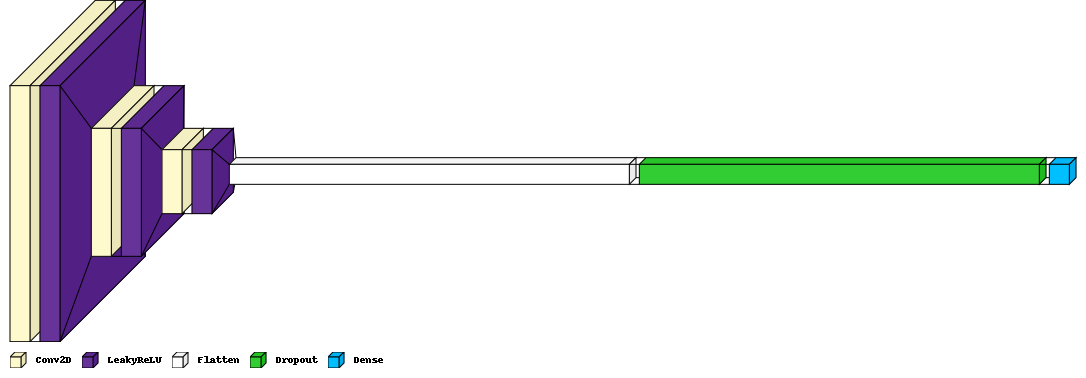

In [ ]:
import visualkeras
from PIL import ImageFont
from collections import defaultdict

color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'lemonchiffon'
color_map[Conv2DTranspose]['fill'] = 'gold'
color_map[Reshape]['fill'] = 'black'
color_map[BatchNormalization]['fill'] = 'red'
color_map[LeakyReLU]['fill'] = 'rebeccapurple'
color_map[Flatten]['fill'] = 'white'

color_map[Dropout]['fill'] = 'limegreen'
color_map[Dense]['fill'] = 'deepskyblue'
color_map[UpSampling2D]['fill'] = 'gray'

visualkeras.layered_view(discriminator, legend=True,color_map=color_map)


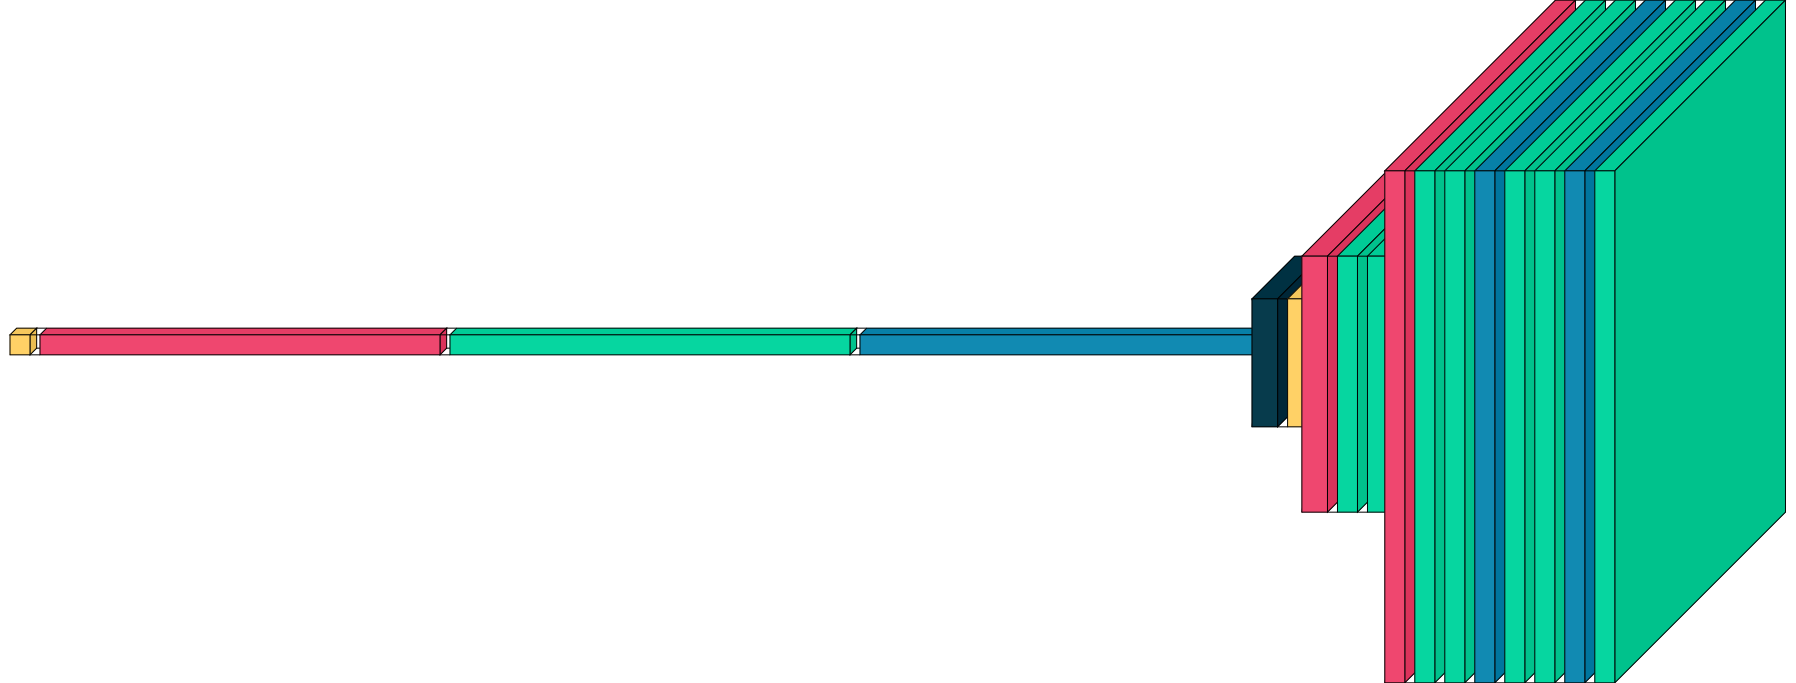

In [ ]:
visualkeras.layered_view(generator)